In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from segment_anything.build_sam import build_sam_vit_b
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from tqdm import tqdm
from dataset_processing.dataset import SAMDataset
from dataset_processing.preprocess import collate_fn
from utils.config import load_config

config = load_config('config.toml')
n_points = config.dataset.n_points
dataset_path = config.cytomine.dataset_path
batch_size = config.training.batch_size
prompt_type = {'points':config.dataset.points, 'box':config.dataset.box, 'neg_points':config.dataset.negative_points}
n_points = config.dataset.n_points
inside_box = config.dataset.negative_points_inside_box
points_near_center = config.dataset.points_near_center
random_box_shift = config.dataset.random_box_shift

dataset = SAMDataset(dataset_path, prompt_type=prompt_type, n_points=n_points, verbose=True, to_dict=True, neg_points_inside_box=inside_box, points_near_center=points_near_center, random_box_shift=random_box_shift)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
model = build_sam_vit_b(config['sam']['checkpoint_path'])
model.to('cuda')
model.eval()
dice_scores = []





Loading images and masks paths...


Computing boxes...: 100%|██████████| 385/385 [00:01<00:00, 297.04it/s]


Done!


  0%|          | 0/193 [00:00<?, ?it/s]

0.8341232928918441


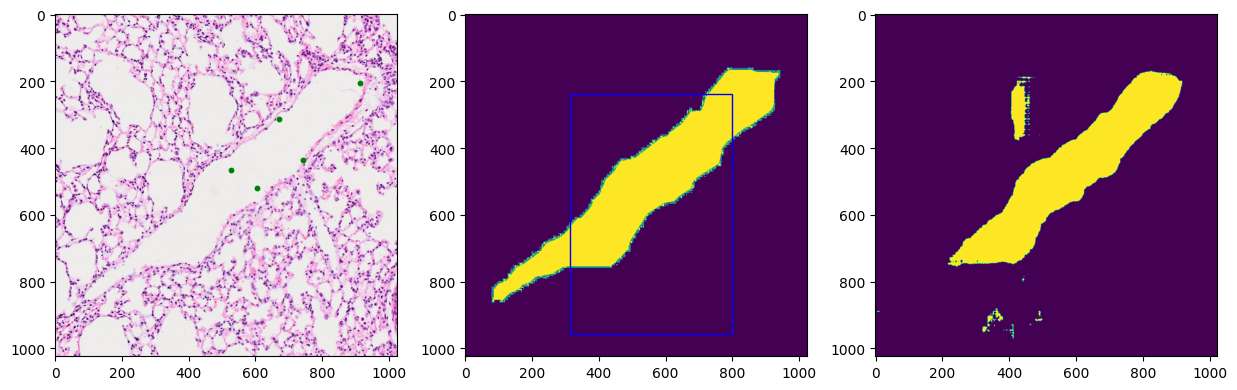

0.4663870767319043


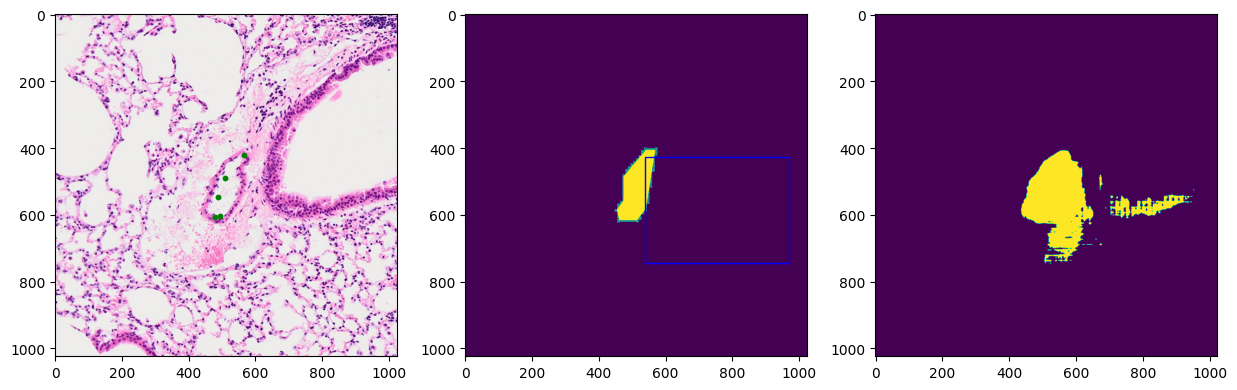

  1%|          | 1/193 [00:03<09:42,  3.03s/it]

0.500719208065443


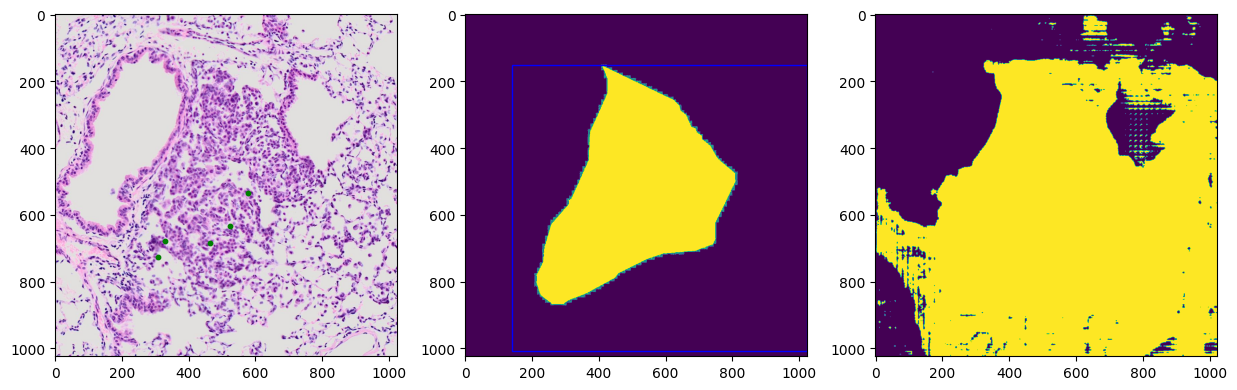

0.2916085814199241


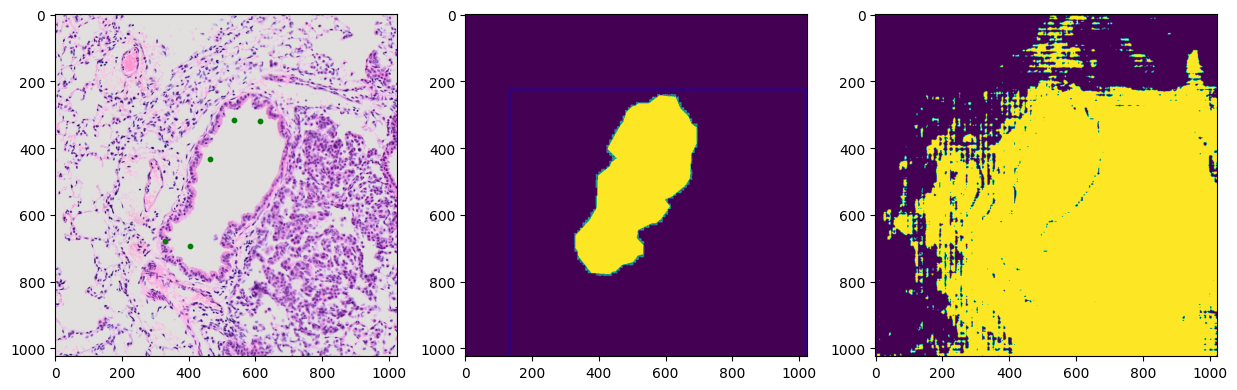

  1%|          | 2/193 [00:05<07:50,  2.47s/it]

0.8189928057553957


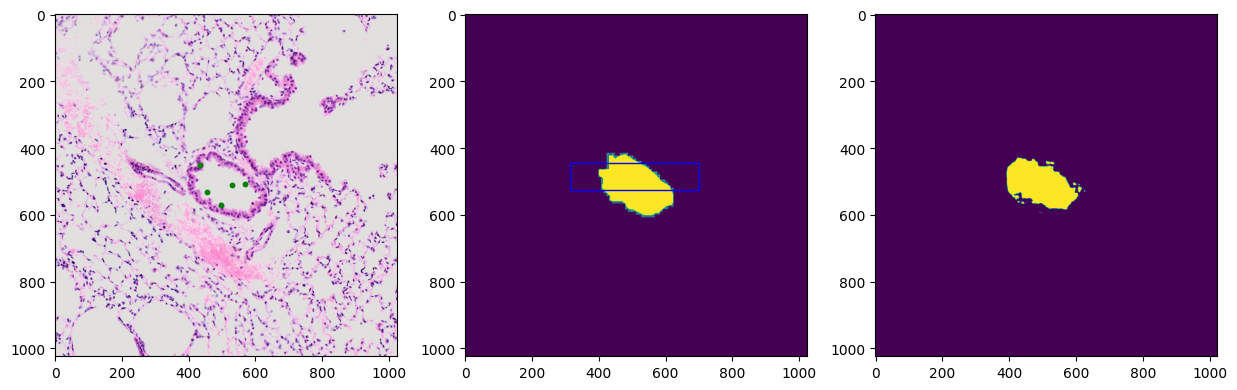

0.8285982213080041


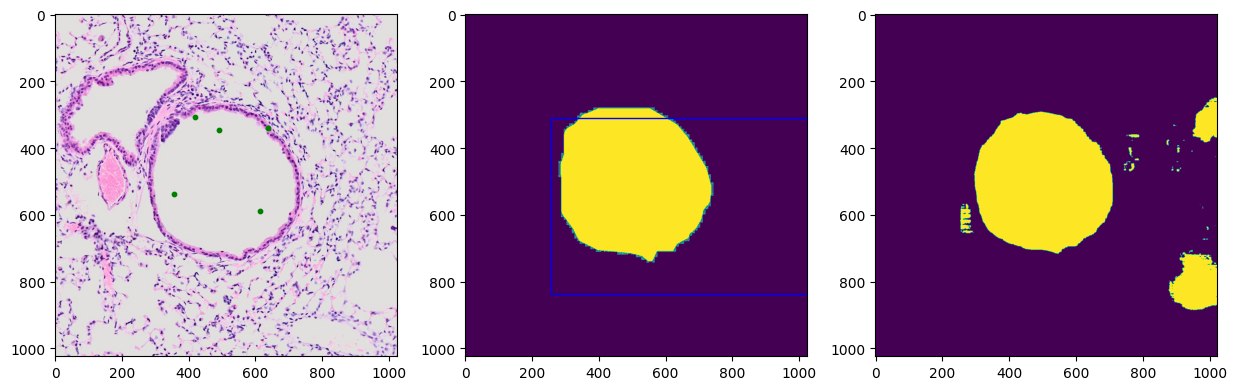

  2%|▏         | 3/193 [00:07<07:14,  2.29s/it]

0.9299453415112446


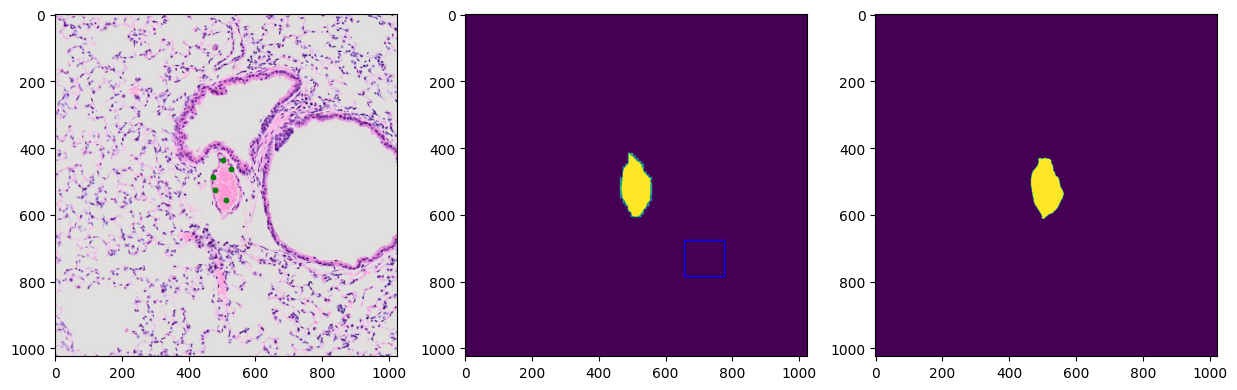

0.5660332794029075


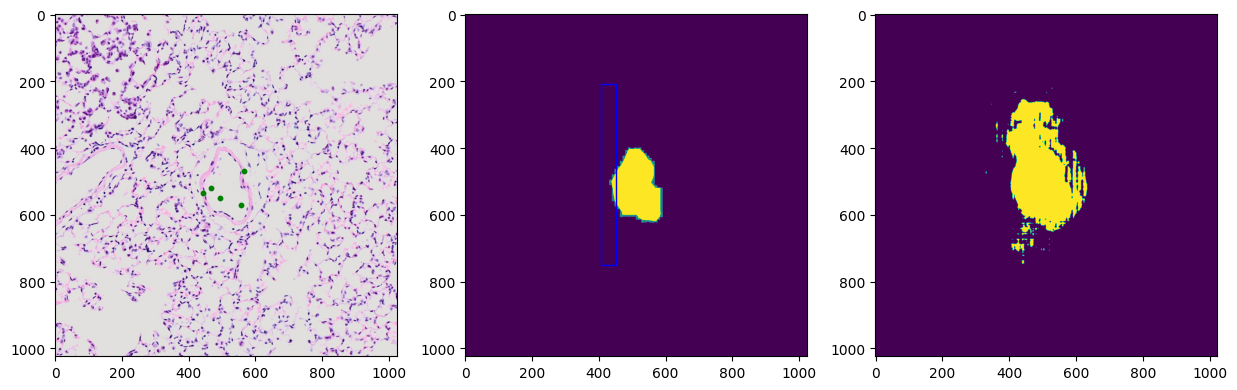

  2%|▏         | 4/193 [00:09<06:53,  2.19s/it]

0.41281860187807423


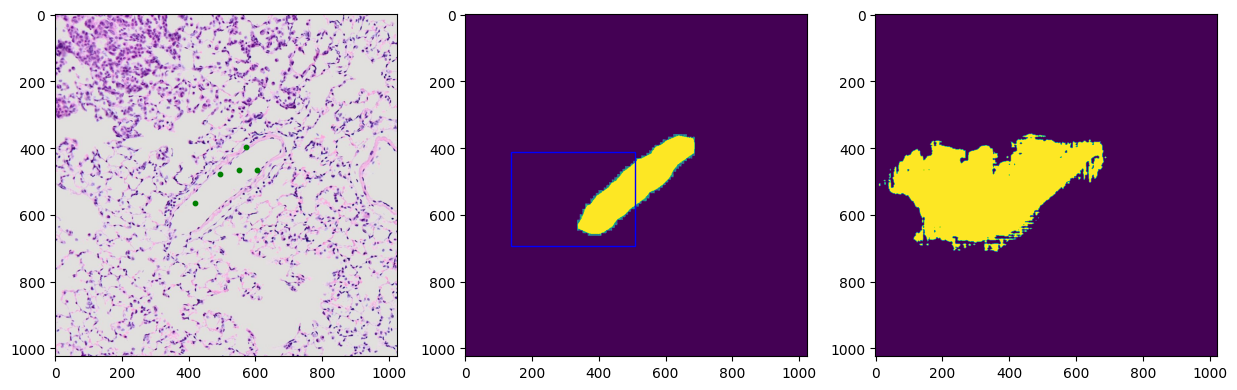

0.3915857370808379


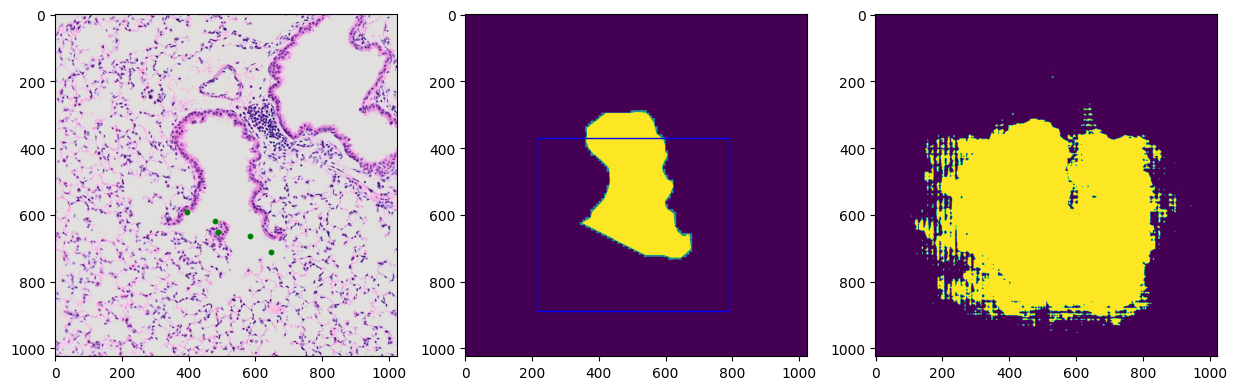

  3%|▎         | 5/193 [00:11<06:50,  2.18s/it]

0.2599334374787747


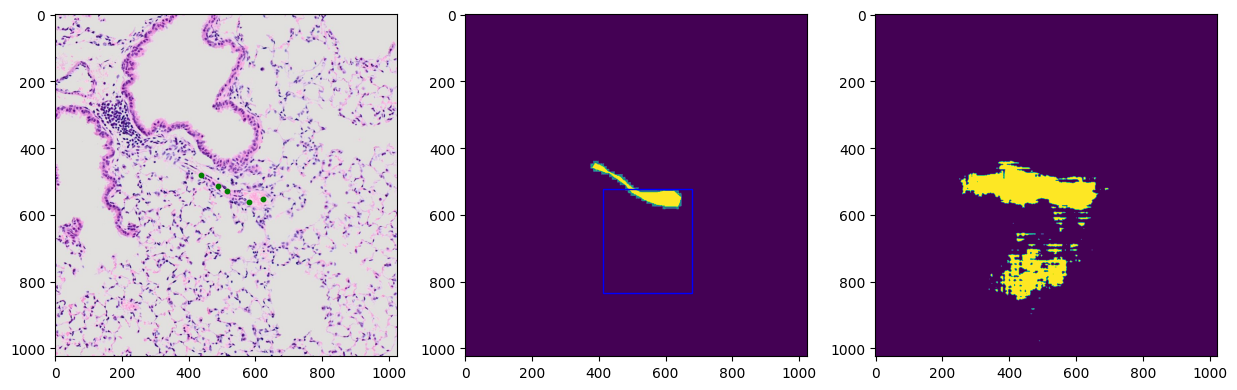

0.7247469417733916


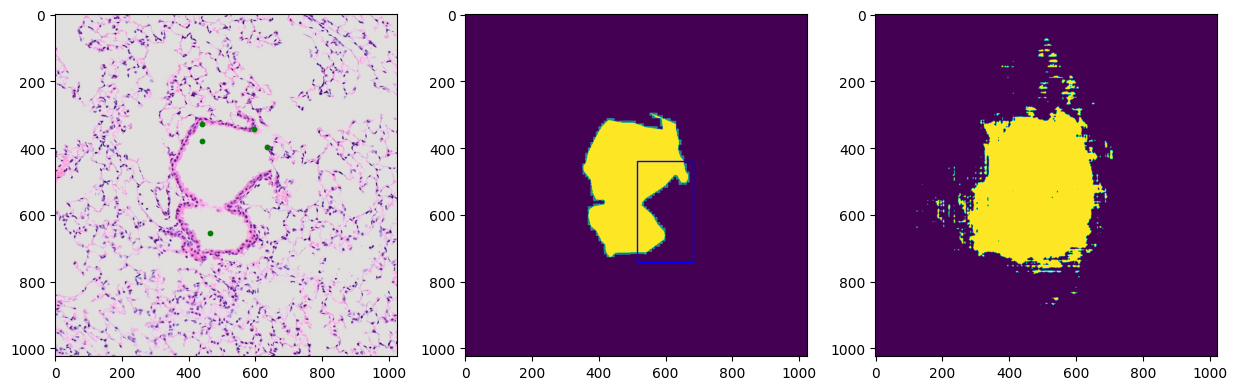

  3%|▎         | 6/193 [00:13<06:43,  2.16s/it]

0.7345814977973567


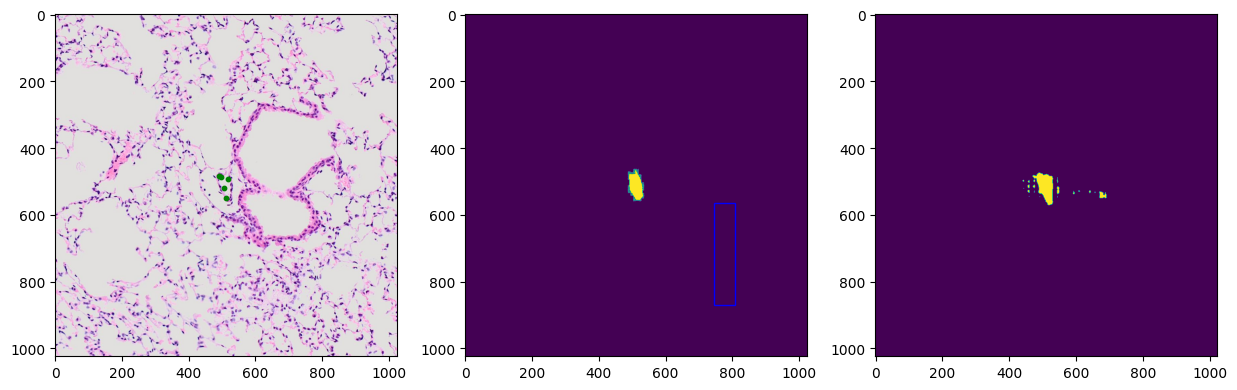

0.32033829252188084


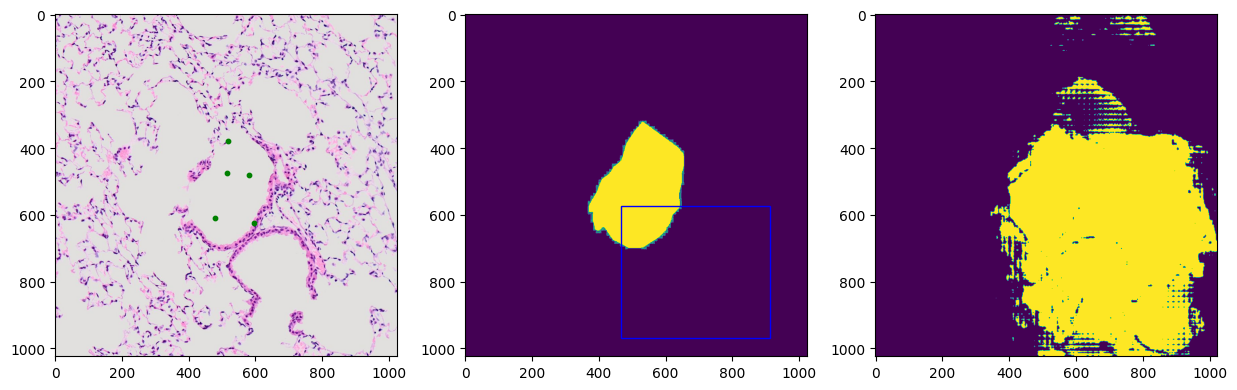

  4%|▎         | 7/193 [00:15<06:38,  2.14s/it]

0.1673002852454563


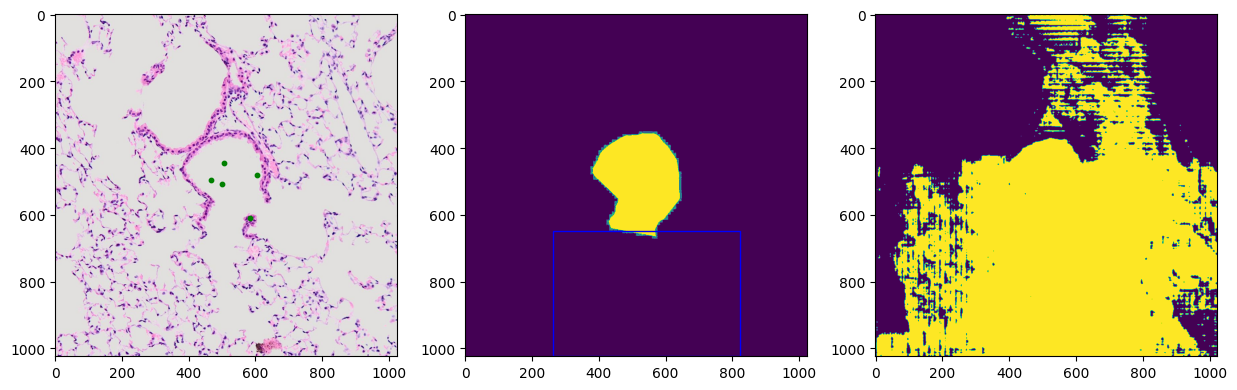

0.25692634857878816


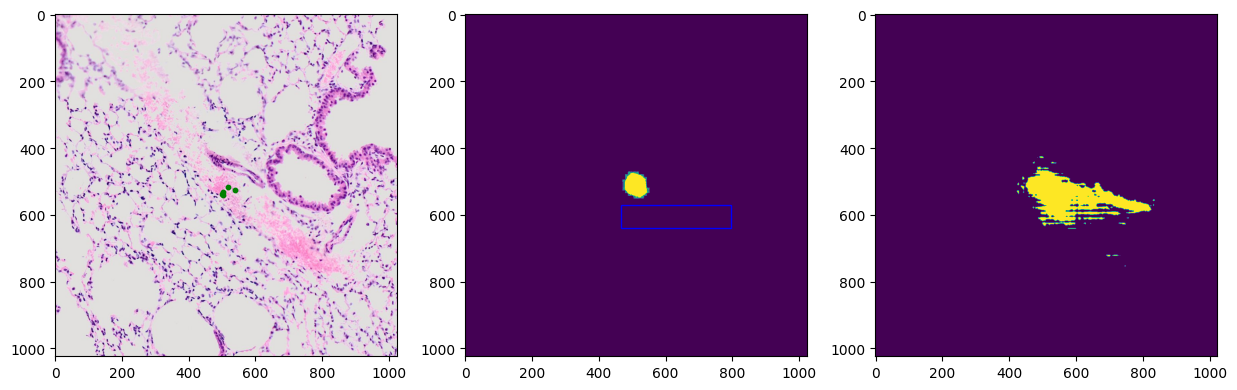

  4%|▍         | 8/193 [00:17<06:33,  2.12s/it]

0.21530339842226817


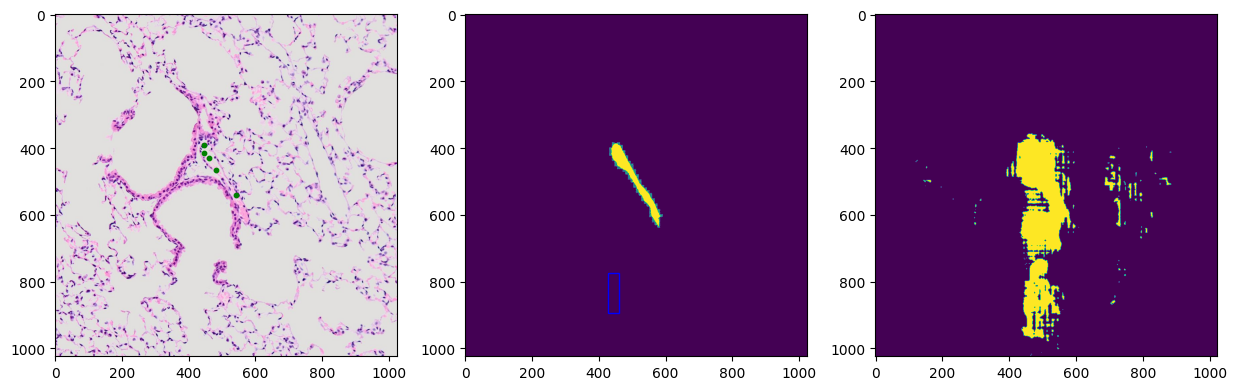

0.6415442306510113


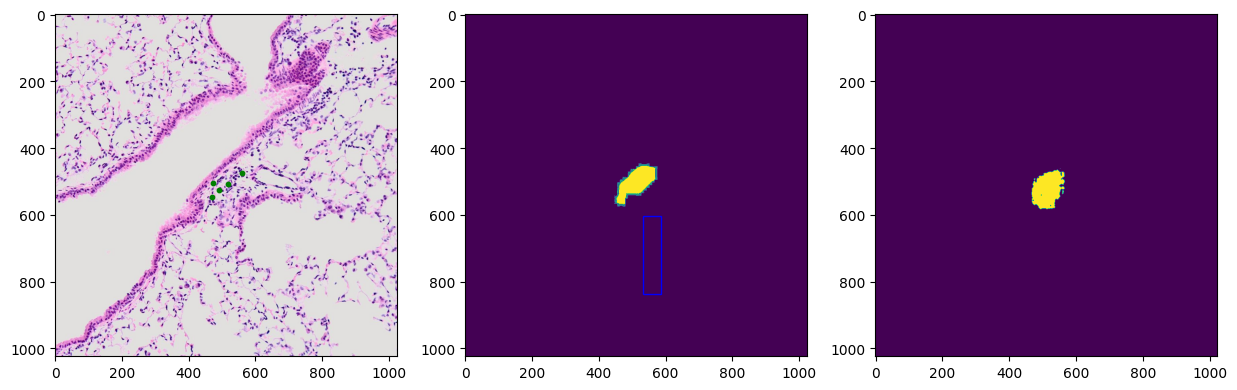

  5%|▍         | 9/193 [00:19<06:29,  2.12s/it]

0.29415553501918285


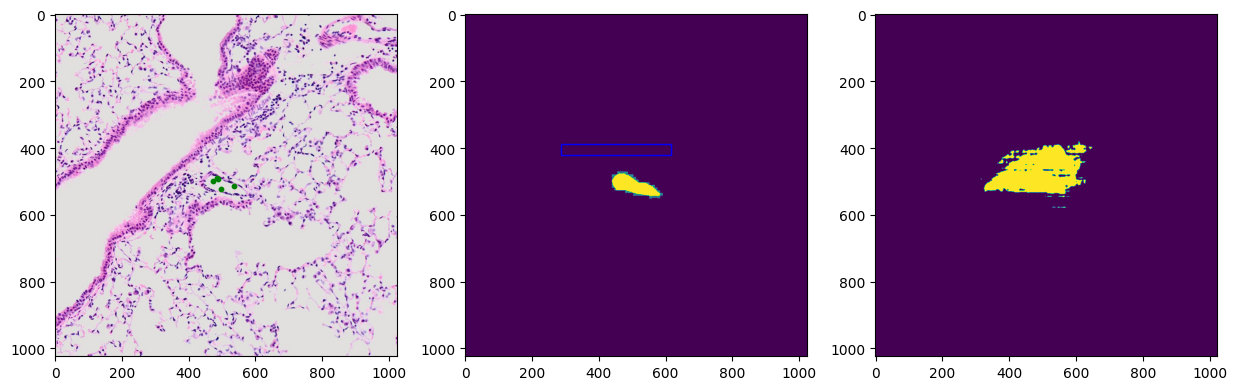

0.5724773635696223


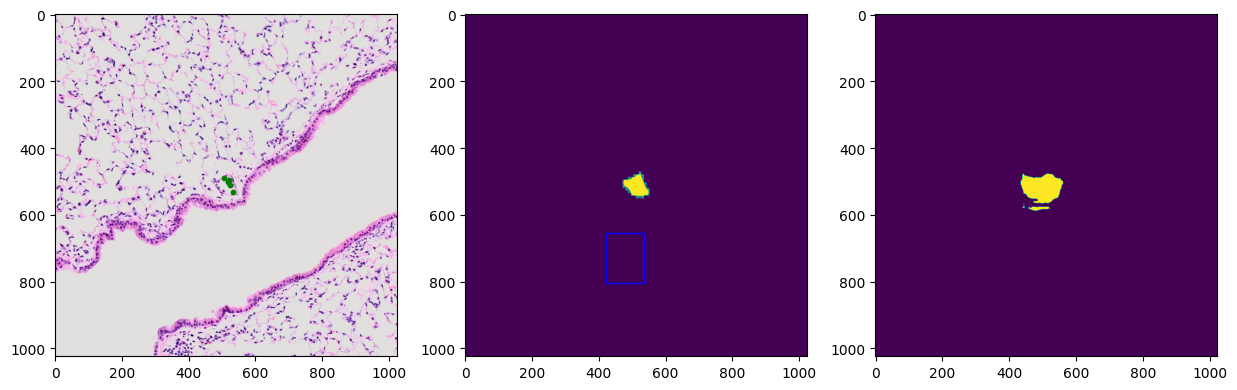

  5%|▌         | 10/193 [00:22<06:33,  2.15s/it]

0.3878834173096211


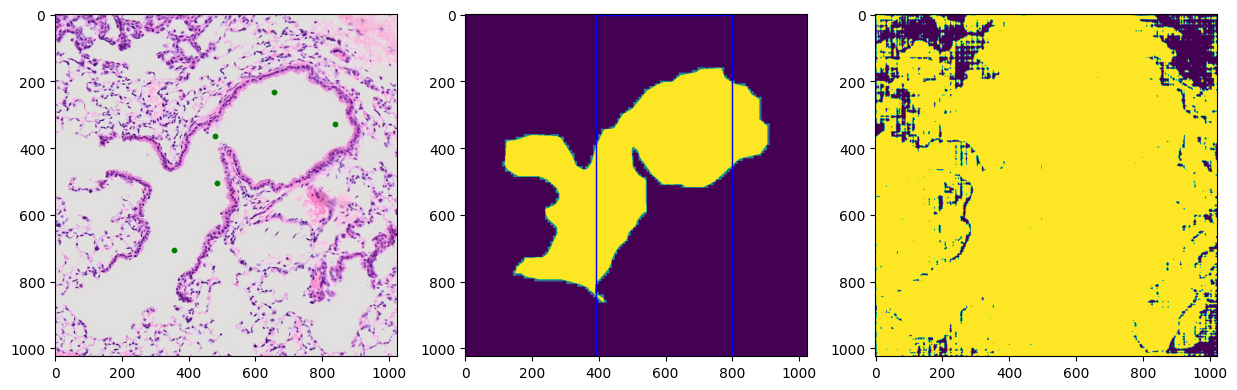

0.2189667336696796


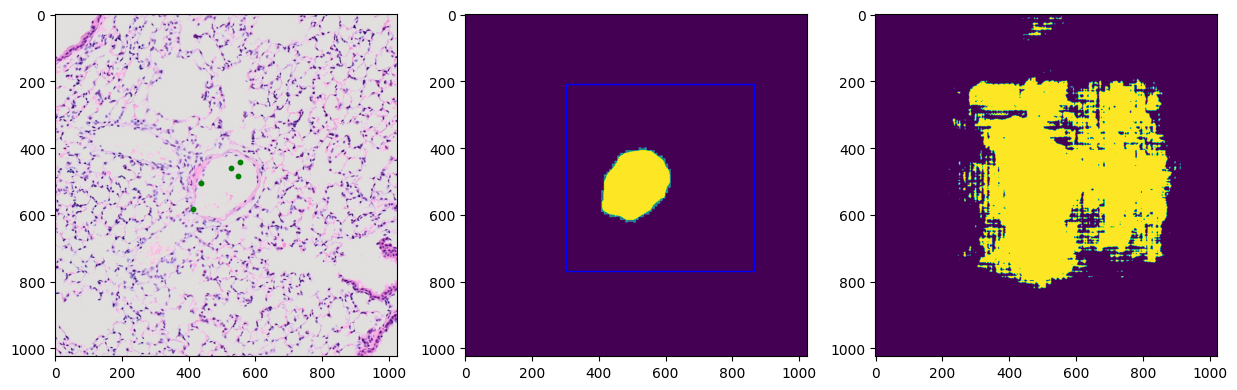

  6%|▌         | 11/193 [00:24<06:28,  2.13s/it]

0.20143480860160512


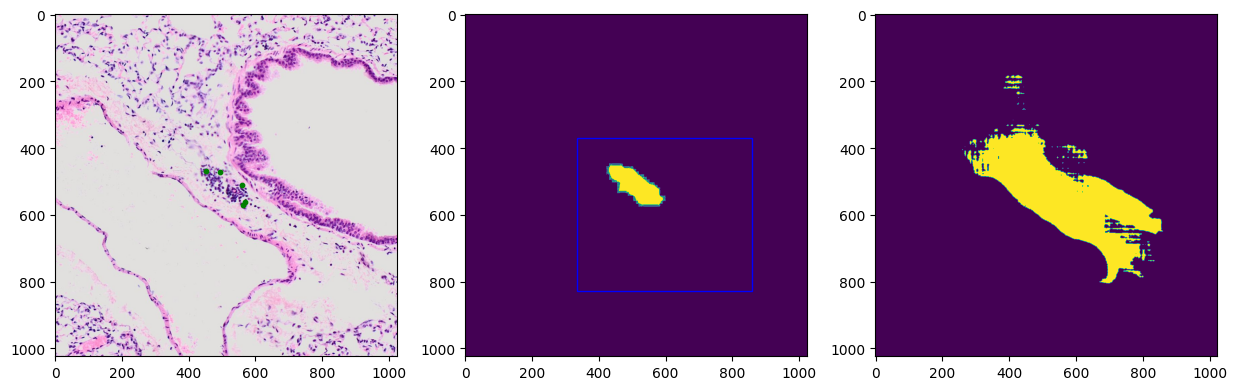

0.702125110807638


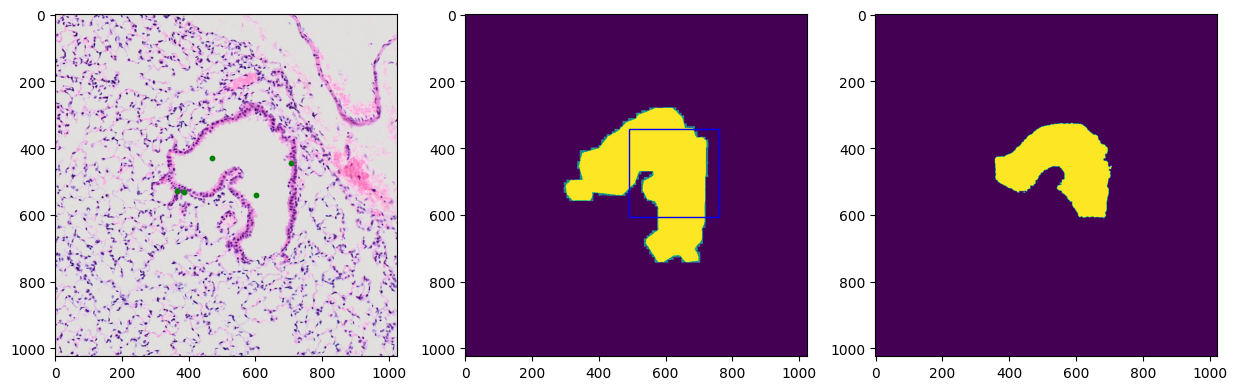

  6%|▌         | 12/193 [00:26<06:23,  2.12s/it]

0.3189691536456599


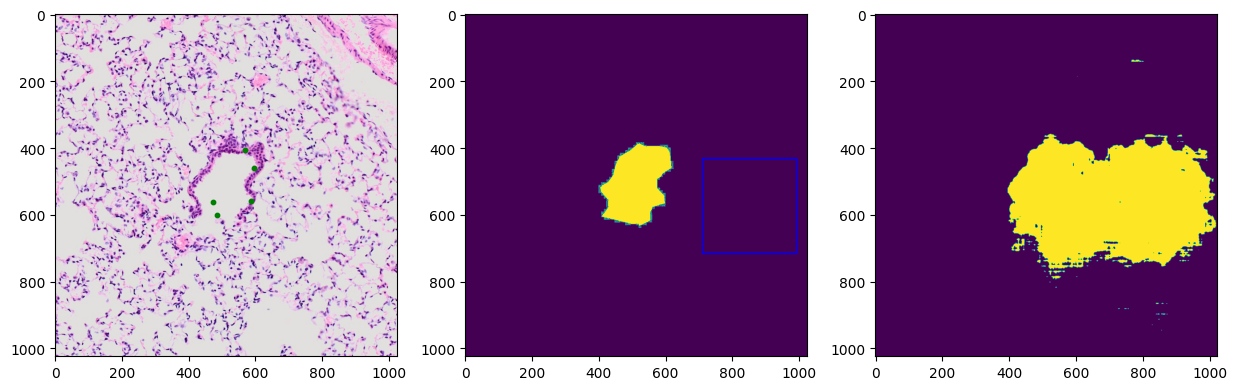

0.23766853536195817


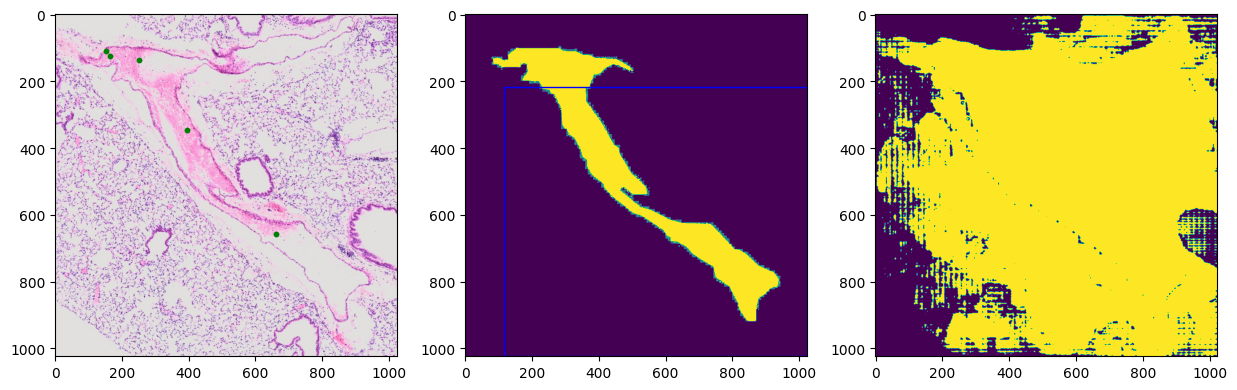

  7%|▋         | 13/193 [00:29<06:43,  2.24s/it]

0.06423202357906485


KeyboardInterrupt: 

In [2]:
with torch.no_grad():
    for data, mask in tqdm(dataloader):
        pred = model(data, multimask_output=True)
        for i in range(len(pred)):
            best_pred = pred[i]['masks'][0][pred[i]['iou_predictions'].argmax()].cpu().numpy()
            dice_scores.append(f1_score(np.array(best_pred.flatten(), dtype=mask[i].dtype), mask[i].flatten()))
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(np.array(data[i]['image'].cpu().permute(1, 2, 0).numpy(), dtype=np.uint8))
            axes[0].scatter(data[i]['point_coords'][:, :n_points, 0].cpu(), data[i]['point_coords'][:,:n_points, 1].cpu(), c='g', s=10)
            #print(data[i]['point_coords'][:, n_points:, 0].cpu().shape)
            axes[0].scatter(data[i]['point_coords'][:, n_points:, 0].cpu(), data[i]['point_coords'][:, n_points:, 1].cpu(), c='r', s=5)
            box = data[i]['boxes'][0].cpu().numpy()
            axes[1].add_patch(plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, edgecolor='b'))
            axes[1].imshow(mask[i])
            axes[2].imshow(best_pred)
            print(dice_scores[-1])
            plt.show()

print(f"Mean Dice score: {np.mean(dice_scores)}")